In [ ]:
import imaging_behavior_functions
#import odor_behavioral_analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy import optimize
import scipy.io
import os
import mat73
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
from scipy.stats import iqr
from PIL import Image
import cv2
from IPython.display import display, clear_output
import time
import seaborn as sns
from scipy.stats import iqr
from scipy.ndimage import gaussian_filter1d
import glob
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tensorflow as tf
from torchsummary import summary
from scipy.stats import circmean, circstd

### Load old

In [24]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/hDeltaB_imaging/qualified_sessions/jump/"
folder_name = "20230517-3_MBON09hDeltaB_syntGCAMP7f_long_jump"
example_path_data = base_path+f"{folder_name}/data/"
example_path_results = base_path+f"{folder_name}/results/"
trial_num = 2
#odor_threshold = 5
bar_jump = False

is_mat73, roi_df, dff_raw, kinematics_raw, preprocessed_vars_ds, preprocessed_vars_odor = imaging_behavior_functions.load_intermediate_mat(example_path_data,trial_num)
behav_df = imaging_behavior_functions.make_df_behavior(dff_raw, preprocessed_vars_ds, preprocessed_vars_odor,trial_num,ball_d = 9)
behav_df = imaging_behavior_functions.reconstruct_path(behav_df, ball_d = 9)
if bar_jump:
    behav_df = imaging_behavior_functions.compute_absolute_circular_diff(behav_df)
    behav_df = imaging_behavior_functions.detect_local_peaks(behav_df, init_t=10, prominence=0.1, min_time_gap=60)
roi_names, hdeltab_index, epg_index, fr1_index, hdeltab_sequence, epg_sequence, fr1_sequence = imaging_behavior_functions.get_roi_seq(roi_df)
dff_all_rois, dff_time = imaging_behavior_functions.load_dff_raw(is_mat73, dff_raw)
neural_df = imaging_behavior_functions.make_df_neural(dff_all_rois, dff_time, roi_names, hdeltab_index, epg_index, fr1_index, hdeltab_sequence, epg_sequence, fr1_sequence)
#behav_df, padded_result_df, smoothed_df = odor_behavioral_analysis.analysis_dfs(behav_df, time_interval_threshold, k, window_size)
combined_df = imaging_behavior_functions.combine_df(behav_df, neural_df)
#smoothed_df["translationalV_smoothed"] = np.sqrt(smoothed_df["fwV_smoothed"]**2+smoothed_df["sideV_smoothed"]**2)

In [25]:
behav_df

,time,fwV,sideV,yawV,heading,abssideV,absyawV,net_motion,net_motion_state,heading_adj,odor,xPos,yPos
0,0.000000,0.000000,0.000000,0.000000,4.668550,0.000000,0.000000,0.000000,0,4.668550,0,0.000000,0.000000
1,0.240513,0.920712,-12.209755,-4.587285,4.571852,12.209755,4.587285,17.717753,1,4.571852,0,-0.167960,0.042338
2,0.481026,0.257430,-1.682556,-3.523187,4.138059,1.682556,3.523187,5.463173,1,4.138059,0,-0.207300,0.064987
3,0.721539,1.405668,-8.278464,-5.172633,4.069592,8.278464,5.172633,14.856765,1,4.069592,0,-0.426891,0.190547
4,0.962052,0.527885,-3.114793,-0.220508,3.963693,3.114793,0.220508,3.863187,1,3.963693,0,-0.513888,0.228608
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2490,598.877285,3.003833,-0.372376,2.408172,2.095496,0.372376,2.408172,5.784381,1,-23.037246,0,-178.397982,157.320472
2491,599.117798,0.243480,-3.002783,-0.989662,2.104643,3.002783,0.989662,4.235926,1,-23.028098,0,-178.374458,157.283112
2492,599.358311,-0.334739,-0.661456,0.275579,2.128497,0.661456,0.275579,1.271774,1,-23.004244,0,-178.316613,157.351773
2493,599.598824,0.339760,2.815691,0.330911,2.146475,2.815691,0.330911,3.486362,1,-22.986266,0,-178.416519,157.276460


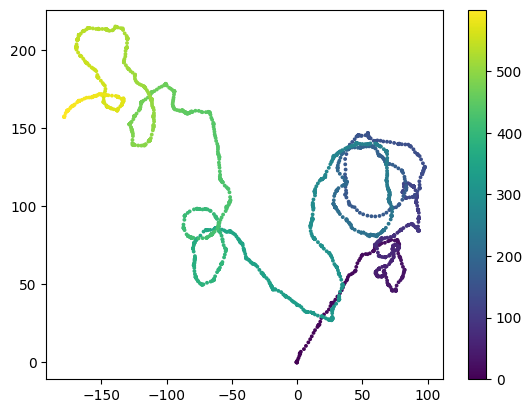

In [26]:
fig = plt.scatter(behav_df.xPos,behav_df.yPos,s=3,c = behav_df.time)
plt.colorbar(fig)

In [27]:
jumpbar_pd = pd.read_csv(example_path_data+'../panel_heading_1.txt',names = ['panel_heading','time','count'])
jumpbar_pd

,panel_heading,time,count
0,0.000000,0.020994,1
1,0.000000,0.027992,2
2,0.000080,0.032990,3
3,6.283024,0.037988,4
4,6.282815,0.043989,5
...,...,...,...
30976,4.841745,617.440808,30977
30977,4.854375,617.460801,30978
30978,4.856249,617.481795,30979
30979,4.854501,617.500788,30980


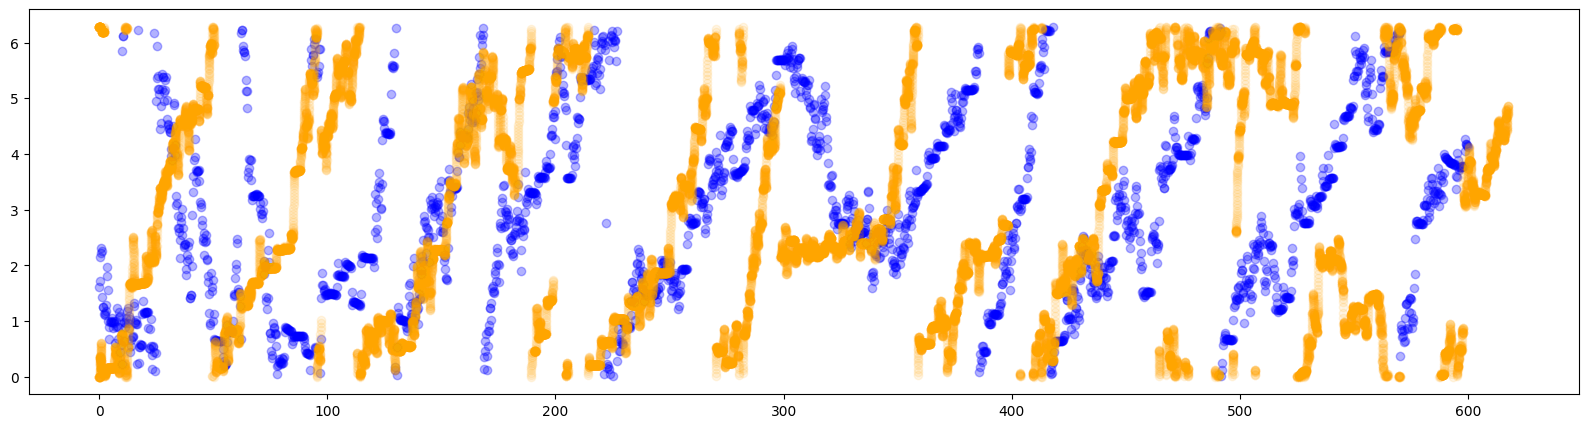

In [31]:
fig_ex, ax = plt.subplots(figsize=[20,5])
x1 = 3000
x2 = 0
ax.scatter(behav_df.time[0:len(behav_df)], 2*np.pi-behav_df.heading[0:len(behav_df)],color ='blue',alpha = 0.3)
ax.scatter(jumpbar_pd.time[:len(jumpbar_pd)-x2], jumpbar_pd.panel_heading[x2:len(jumpbar_pd)],color ='orange',alpha = 0.1)


In [17]:
heading_intp = np.interp(behav_df.time, jumpbar_pd.time[:-x2], 2*np.pi-jumpbar_pd.panel_heading[x2:])
behav_df['heading_jump'] = heading_intp

In [18]:
heading_adj = 2*np.pi-jumpbar_pd.panel_heading[x2:]
jump_label = np.abs(np.diff(np.unwrap(heading_adj)))>2 
jump_idx = np.where(jump_label)

Text(0, 0.5, 'fw velocity (mm/s)')

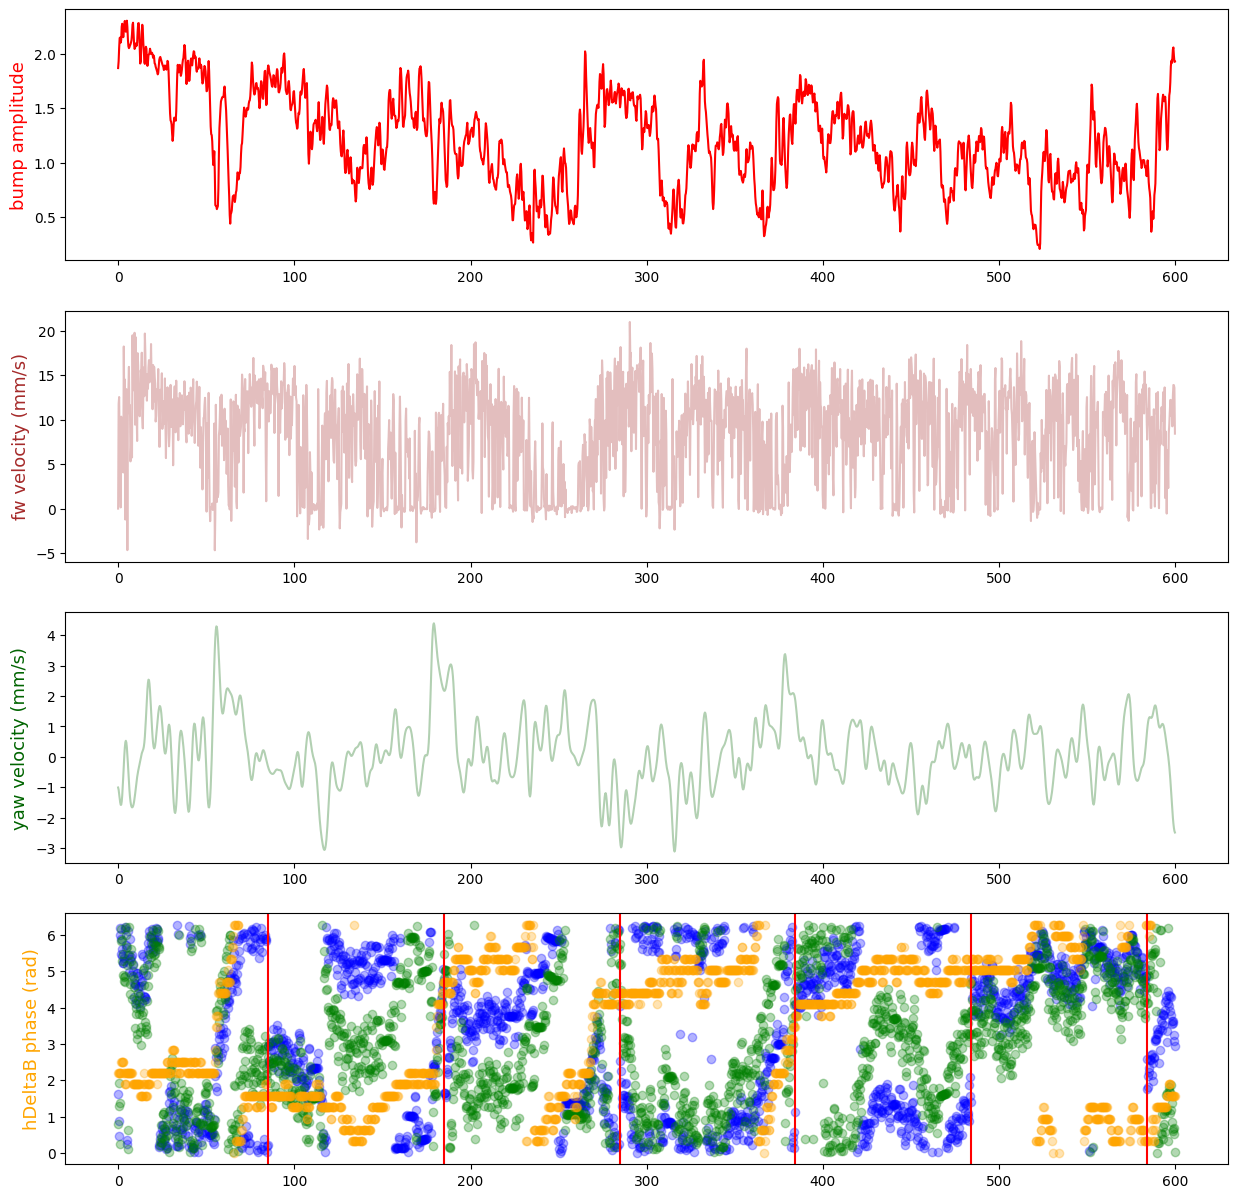

In [20]:
fig_ex, ax = plt.subplots(4,1,figsize=[15,15])
ind1 = 0
ind2 = len(behav_df) 
ax[0].plot(behav_df.time[ind1:ind2], param_df.amplitude[ind1:ind2],color = 'red')
ax[0].set_ylabel('bump amplitude', fontsize = 13, color = 'red')
ax[3].scatter(behav_df.time[ind1:ind2], heading_intp[ind1:ind2],color ='blue',alpha = 0.3)
ax[3].scatter(behav_df.time[ind1:ind2], behav_df.heading[ind1:ind2],color ='green',alpha = 0.3)
ax[3].scatter(behav_df.time[ind1:ind2], 2*np.pi-param_df.phase[ind1:ind2],color ='orange',alpha = 0.3)
#ax[3].scatter(jumpbar_pd.time[:-600], 2*np.pi-jumpbar_pd.panel_heading[600:],color ='orange',alpha = 0.1)
for i in range(len(jump_idx[0])):
    ax[3].axvline(jumpbar_pd.time[jump_idx[0][i]],color ='red')
ax[3].set_ylabel('hDeltaB phase (rad)', fontsize = 13, color = 'orange')
#ax2 = ax[3].twinx()
ax[2].plot(behav_df.time[ind1:ind2], imaging_behavior_functions.apply_gaussian_smoothing(behav_df.yawV[ind1:ind2],5),color='darkgreen',alpha = 0.3)
ax[2].set_ylabel('yaw velocity (mm/s)', fontsize = 13, color = 'darkgreen')
ax[1].plot(behav_df.time[ind1:ind2],behav_df.fwV[ind1:ind2], color = 'brown',alpha = 0.3)
ax[1].set_ylabel('fw velocity (mm/s)', fontsize = 13, color = 'brown')

In [13]:
# Function to find the index of the closest value
def find_closest_indices(values, highlight_values):
    indices = []
    for value in highlight_values:
        # Compute absolute difference and find the index of the minimum
        index = np.abs(values - value).argmin()
        indices.append(index)
    return indices

In [14]:
highlight_times = np.array(jumpbar_pd.time[jump_idx[0]])
# Find the index of the closest value for each highlight value
highlight_indices = find_closest_indices(behav_df.time, highlight_times)

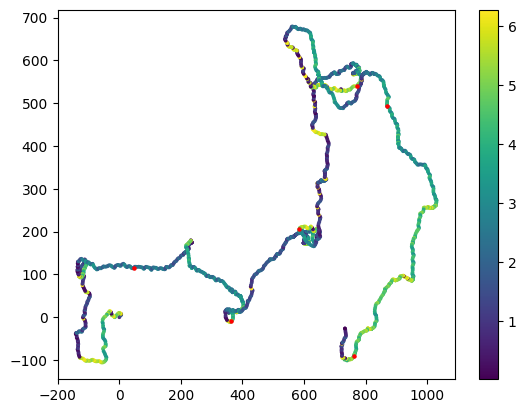

In [15]:
fig = plt.scatter(xPos,yPos,s=3,c = behav_df.heading)
# Highlight specific time points in red
for idx in highlight_indices:
    plt.scatter(xPos[idx], yPos[idx], s=5,color='red')
plt.colorbar(fig)

### Load new

In [7]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/standby/"
folder_name = "20250212-2_FB4R-noodor"
example_path_data = base_path+f"{folder_name}/data/"
example_path_results = base_path+f"{folder_name}/results/"
trial_num = 2
bar_jump = True
is_mat73, roi_df, dff_raw = imaging_behavior_functions.load_intermediate_mat_new(example_path_data,trial_num)
roi_names, hdeltab_index, epg_index, fr1_index, hdeltab_sequence, epg_sequence, fr1_sequence = imaging_behavior_functions.get_roi_seq(roi_df)
dff_all_rois, dff_time = imaging_behavior_functions.load_dff_raw(is_mat73, dff_raw)
neural_df = imaging_behavior_functions.make_df_neural(dff_all_rois, dff_time, roi_names, hdeltab_index, epg_index, fr1_index, hdeltab_sequence, epg_sequence, fr1_sequence)
behav_df, neural_df_new = imaging_behavior_functions.load_matfile_to_df(example_path_data, folder_name, trial_num,is_odor_trial=True)
behav_df = imaging_behavior_functions.rename_dataframe(behav_df)
if bar_jump:
    behav_df = imaging_behavior_functions.compute_absolute_circular_diff(behav_df)
    behav_df = imaging_behavior_functions.detect_local_peaks(behav_df, init_t=10, prominence=0.1, min_time_gap=60)
#behav_df = imaging_behavior_functions.detect_jumps_unwrapped(behav_df, 'heading', 'time', jump_threshold=np.pi/4, min_time_between_jumps=60)
behav_df = imaging_behavior_functions.make_df_behavior_new(behav_df)
#behav_df, block_boundaries = imaging_behavior_functions.label_blocks_5_v2(behav_df,50,time_lengths=[300,120,300],detection_threshold=0.05,required_consecutive=5)
#behav_df, block_boundaries = imaging_behavior_functions.label_blocks_3(behav_df,50)

#behav_df = imaging_behavior_functions.calc_segment_modes_filtered_v2(behav_df)
behav_df = imaging_behavior_functions.calculate_theta_g_rho(behav_df)

#behav_df, block_boundaries = imaging_behavior_functions.label_blocks_3(behav_df,50)
# Get both filtered data and mask
'''motion_threshold=1
behav_df, motion_mask = filter_by_motion(behav_df, 
                                                motion_threshold, 
                                                return_mask=True)'''
# Apply same mask to neural_df if needed
#neural_df = neural_df[motion_mask]
merged_df = imaging_behavior_functions.merge_dataframes(neural_df, behav_df)
# Calculate odor metrics: duration and past interval
onset_indices = merged_df.index[(merged_df["odor_state"].shift(1, fill_value=0) == 0) & (merged_df["odor_state"] == 1)]
offset_indices = merged_df.index[(merged_df["odor_state"].shift(1, fill_value=0) == 1) & (merged_df["odor_state"] == 0)]

merged_df["odor_duration"] = np.nan
merged_df["past_interval"] = np.nan

for onset_idx in onset_indices:
    # Find the first offset after the onset
    offset_idx = offset_indices[offset_indices > onset_idx].min()

    if pd.notna(offset_idx):
        # Calculate odor duration
        odor_duration = merged_df.loc[offset_idx, "time"] - merged_df.loc[onset_idx, "time"]
        merged_df.loc[onset_idx, "odor_duration"] = odor_duration

    # Calculate past interval
    last_offset_idx = offset_indices[offset_indices < onset_idx].max()
    if pd.notna(last_offset_idx):
        past_interval = merged_df.loc[onset_idx, "time"] - merged_df.loc[last_offset_idx, "time"]
    else:
        past_interval = merged_df.loc[onset_idx, "time"] - merged_df["time"].iloc[0]
    merged_df.loc[onset_idx, "past_interval"] = past_interval
#xPos, yPos = imaging_behavior_functions.reconstruct_path(behav_df, ball_d = 9)
#behav_df = imaging_behavior_functions.label_block(behav_df, 150)
# Initialize the new column
merged_df["odor_heading_avg"] = np.nan

# Compute average heading during each odor-on period
for onset_idx in onset_indices:
    offset_idx = offset_indices[offset_indices > onset_idx].min()
    if pd.notna(offset_idx):
        avg_heading = circmean(merged_df.loc[onset_idx:offset_idx, "heading"])
        merged_df.loc[onset_idx, "odor_heading_avg"] = avg_heading

Loaded using mat73.


In [13]:
merged_df

,xPos,yPos,fwV,sideV,odor,yawV,heading,heading_diff,time,odor_state,...,net_motion_state,heading_adj,speed,theta_g,rho_t,FB4R_CRE,FB4R_FB,odor_duration,past_interval,odor_heading_avg
0,0.000000,0.000000,-2.621721,-0.288366,-0.094642,-0.295183,3.824409,0.295679,0.000000,True,...,1,3.824409,2.653999,4.722931,0.689139,0.190102,0.313689,1.201398,0.0,4.019279
1,0.426732,-0.203116,-1.302901,2.477613,-0.038359,0.957954,3.784528,-0.763559,0.168830,True,...,1,3.784528,2.958681,4.813960,0.664773,0.097094,0.135737,NaN,NaN,NaN
2,0.954878,-0.249115,-1.043414,2.850076,0.237819,1.287824,3.560341,-1.051290,0.343503,True,...,1,3.560341,3.296989,4.902393,0.643393,0.006623,-0.033674,NaN,NaN,NaN
3,1.003783,-0.755036,-2.841160,-0.900149,0.408162,-0.588301,3.421224,0.470170,0.514046,True,...,1,3.421224,3.037853,4.982364,0.632727,-0.045995,-0.097247,NaN,NaN,NaN
4,0.109687,-1.414344,-3.295864,-5.535748,0.027510,-2.741135,3.726033,2.248679,0.686476,True,...,1,3.726033,7.001503,5.060317,0.621916,-0.101524,-0.090064,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5820,-179.879242,300.547729,5.530797,-1.357643,2.120270,1.103428,0.750862,-0.899298,999.268127,True,...,1,-212.877487,5.800901,1.697770,0.703329,0.330348,0.407110,NaN,NaN,NaN
5821,-179.505341,299.616974,5.475897,-2.141588,2.215099,0.368256,0.673640,-0.301185,999.438721,True,...,1,-212.954697,5.891304,1.623206,0.735074,0.320641,0.452743,NaN,NaN,NaN
5822,-179.282639,298.695831,5.350605,-1.094409,2.246866,0.270437,0.647364,-0.218307,999.612244,True,...,1,-212.980972,5.468075,1.548349,0.767648,0.311880,0.441664,NaN,NaN,NaN
5823,-179.185684,297.871277,4.915172,-0.161669,2.308002,0.574536,0.598658,-0.460221,999.781067,True,...,1,-213.029678,4.951277,1.474095,0.797725,0.315895,0.382249,NaN,NaN,NaN


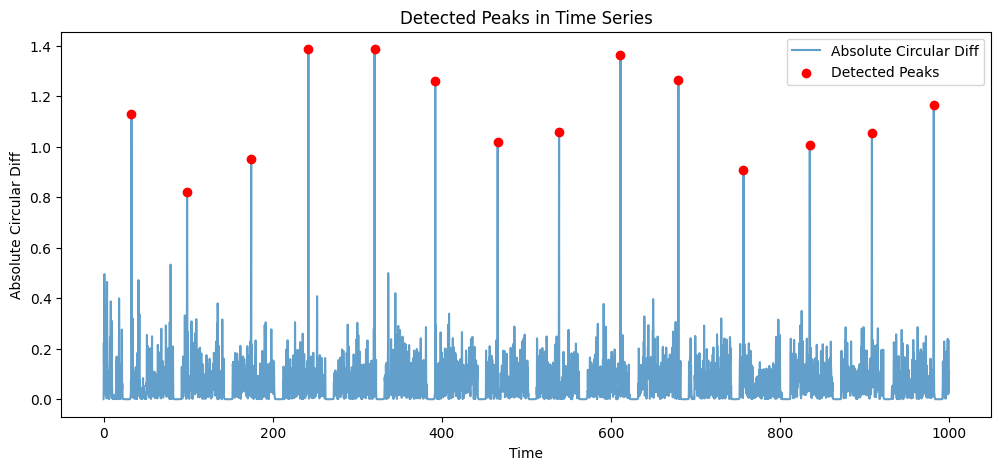

In [10]:
# Plot the data
plt.figure(figsize=(12, 5))
plt.plot(behav_df["time"], behav_df["absolute_circular_diff"], label="Absolute Circular Diff", alpha=0.7)
plt.scatter(behav_df[behav_df["jump_detected"] == 1]["time"], 
            behav_df[behav_df["jump_detected"] == 1]["absolute_circular_diff"], 
            color='red', label="Detected Peaks", zorder=3)
plt.xlabel("Time")
plt.ylabel("Absolute Circular Diff")
plt.legend()
plt.title("Detected Peaks in Time Series")
plt.show()




In [12]:
def plot_aligned_traces(
    df, binary_col, query_col, time_col, color_col=None, align_to="on", window=(-1, 1), bins=None
):
    """
    Plots query variable traces aligned to binary state ON or OFF transitions.
    Colors traces by a third variable (if provided) and optionally bins it.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the data.
    binary_col : str
        Column name of the binary state variable (0 or 1).
    query_col : str
        Column name of the query variable to be plotted.
    time_col : str
        Column name of the time variable.
    color_col : str, optional
        Column name of the variable used for coloring traces. If None, defaults to blue.
    align_to : str, optional
        Whether to align traces to binary state "on" (1) or "off" (0). Default is "on".
    window : tuple, optional
        Time window around the transition (before, after) in the same units as `time_col`. Default is (-1, 1).
    bins : int, optional
        Number of bins for the coloring variable. If None, uses continuous values.

    Returns:
    --------
    None
    """
    # Detect transitions (state changes)
    if align_to == "on":
        transition_idxs = df.index[(df[binary_col] == 1) & (df[binary_col].shift(1) == 0)]
    elif align_to == "off":
        transition_idxs = df.index[(df[binary_col] == 0) & (df[binary_col].shift(1) == 1)]
    else:
        raise ValueError("align_to must be 'on' or 'off'.")

    # Store all extracted traces
    all_traces = []
    time_shifts = []
    colors = []

    # Iterate over transitions
    for idx in transition_idxs:
        t0 = df.loc[idx, time_col]  # Get transition time
        start_time, end_time = t0 + window[0], t0 + window[1]  # Define window range
        subset = df[(df[time_col] >= start_time) & (df[time_col] <= end_time)]  # Extract data

        if not subset.empty:
            aligned_time = subset[time_col] - t0  # Align time to transition (t=0)
            all_traces.append(subset[query_col].values)  # Store query variable values
            time_shifts.append(aligned_time.values)  # Store aligned time values
            colors.append(df.loc[idx, color_col] if color_col else None)  # Store color variable

    # Convert to arrays
    all_traces = np.array(all_traces, dtype=object)
    time_shifts = np.array(time_shifts, dtype=object)

    # Default to blue if no color column is provided
    if color_col is None:
        colors = None
    else:
        colors = np.array(colors)

    # Handle binning of the color variable
    if color_col and bins is not None:
        bin_edges = np.linspace(colors.min(), colors.max(), bins + 1)
        color_bins = np.digitize(colors, bin_edges) - 1  # Bin indices
        unique_bins = np.unique(color_bins)
    else:
        color_bins = colors if colors is not None else None
        unique_bins = np.unique(colors) if colors is not None else None

    # Define colormap
    cmap = cm.get_cmap("viridis", len(unique_bins)) if color_col else None
    norm = mcolors.Normalize(vmin=colors.min(), vmax=colors.max()) if color_col else None

    plt.figure(figsize=(8, 5))

    # Plot individual traces
    for i, (time_trace, query_trace) in enumerate(zip(time_shifts, all_traces)):
        if color_col:
            bin_idx = color_bins[i] if bins is not None else colors[i]
            plt.plot(time_trace, query_trace, alpha=0.3, color=cmap(norm(bin_idx)))
        else:
            plt.plot(time_trace, query_trace, alpha=0.3, color="blue")

    # Plot averaged traces within bins
    if color_col and bins is not None:
        for bin_idx in unique_bins:
            bin_mask = color_bins == bin_idx
            if np.sum(bin_mask) > 0:
                avg_time = np.mean([time_shifts[i] for i in range(len(all_traces)) if bin_mask[i]], axis=0)
                avg_trace = np.mean([all_traces[i] for i in range(len(all_traces)) if bin_mask[i]], axis=0)
                plt.plot(avg_time, avg_trace, linewidth=2, color=cmap(norm(bin_idx)), label=f"Bin {bin_idx+1}")

    # Labels and legend
    plt.xlabel("Time (s, aligned to transition)")
    plt.ylabel(query_col)
    plt.axvline(0, color="k", linestyle="--", linewidth=1)  # Mark transition point
    plt.title(f"{query_col} aligned to {binary_col} {align_to.upper()} transitions")
    
    if color_col:
        plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label=color_col)
    if bins is not None and color_col:
        plt.legend()
    
    plt.grid(True)
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


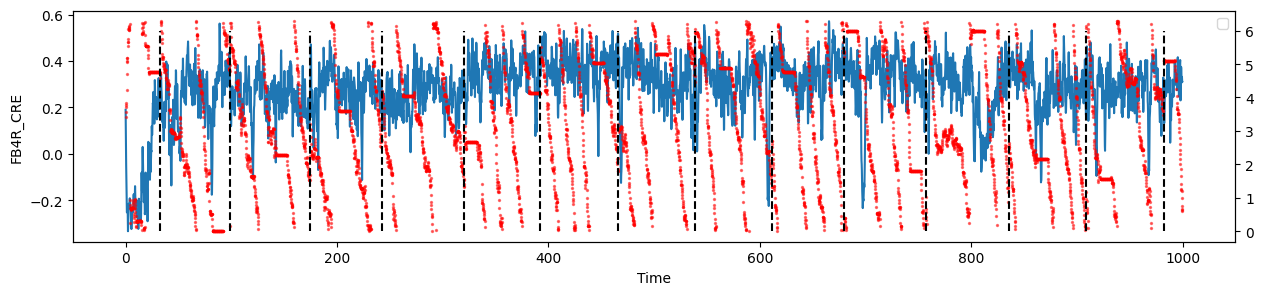

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
idx1 = 0
idx2 = -1
ax.plot(neural_df.time[idx1:idx2], neural_df['FB4R_CRE'][idx1:idx2])
ax2 = ax.twinx()
ax2.scatter(behav_df.time[idx1:idx2], behav_df.heading[idx1:idx2], color='red',s = 2, alpha=0.5)
# Extracting indices where jump_detected is 1
jump_indices = behav_df[behav_df['jump_detected'] == 1].index

# Plotting all vertical lines in a single call
ax2.vlines(behav_df.time[jump_indices], ymin=0, ymax=6, colors='black', linestyles='--', label='Jump Detected')

# Add labels and legends
ax.set_xlabel('Time')
ax.set_ylabel('FB4R_CRE')
#ax.set_xlim(behav_df.time[idx1], behav_df.time[idx2])
ax.legend()

plt.show()

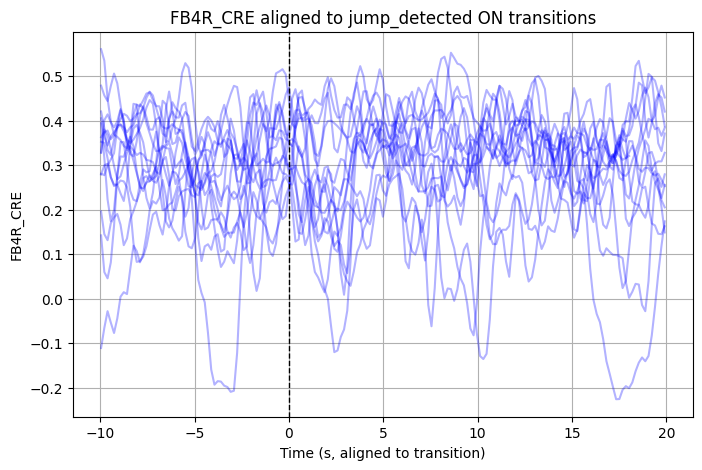

In [15]:
plot_aligned_traces(
    merged_df, 'jump_detected', 'FB4R_CRE', 'time', color_col=None, align_to="on", window=(-10, 20), bins=None
)